# Convolutional Network for MNIST Predictions. 
In this notebook, I will be using a convolutional architecture rather than a fully connected network. The architecture I am adopting is LeNet-5, which has recorded an error rate as low as 0.95 (or %99.05 accurate). I don't know if I will get quite those results, but let's try!

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from sklearn import model_selection

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from collections import OrderedDict

## Custom Dataset Object
Since the dataset provided by Kaggle is not in image format, we can define a custom MNIST dataset object in PyTorch. In the Kaggle dataset, each row of the .csv file represents a single image and its label. The first entry in the row is the image label, while the other 784 entries in the row are the unstacked image pixel values. 

For a convolutional network, we will need to transform those row vectors back into 3D tensors representing actual image data.

In [2]:
class MNIST(Dataset):
    def __init__(self, df, labels=True, transform=None):
        
        self.df = df
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
   
        if self.labels:
            label = self.df.iloc[index, 0]
            data  = self.df.iloc[index, 1:].to_numpy(np.uint8).reshape(28,28, 1)
            if self.transform:
                data = self.transform(data)
            return data, label
    
        data  = self.df.iloc[index].to_numpy(dtype=np.uint8).reshape(28,28, 1)
        
        if self.transform:
            data = self.transform(data)
        
        return data
    
class to_dtype(object):
    def __call__(self, x, dtype=torch.FloatTensor):
        return x.type(dtype)

## Transforms, Datasets and DataLoaders

Next, we define very basic transforms. First, we transform each 28x28 numpy array into a 1x28x28 torch image tensor. Then we normalize the data to help convergence.

In [3]:
augment = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomRotation(10, fill=(0,)),
                                transforms.RandomPerspective(),
                                transforms.RandomAffine(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

tfs = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))])

Let's read in our Kaggle training data, split it (25% validation hold out) and get it into `DataLoaders`:

In [4]:
train_df = pd.read_csv('data/train.csv')
X, y = train_df.iloc[:, 1:], train_df.iloc[:, 0]
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(X, y)

trainset = MNIST(pd.concat([y_train, x_train], axis=1), transform=augment)
validset = MNIST(pd.concat([y_valid, x_valid], axis=1), transform=tfs)

trainload = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
validload = DataLoader(validset, batch_size=32, shuffle=True, num_workers=4)

Just to make sure that everything is looking good before we get started, let's take a look at a few images:


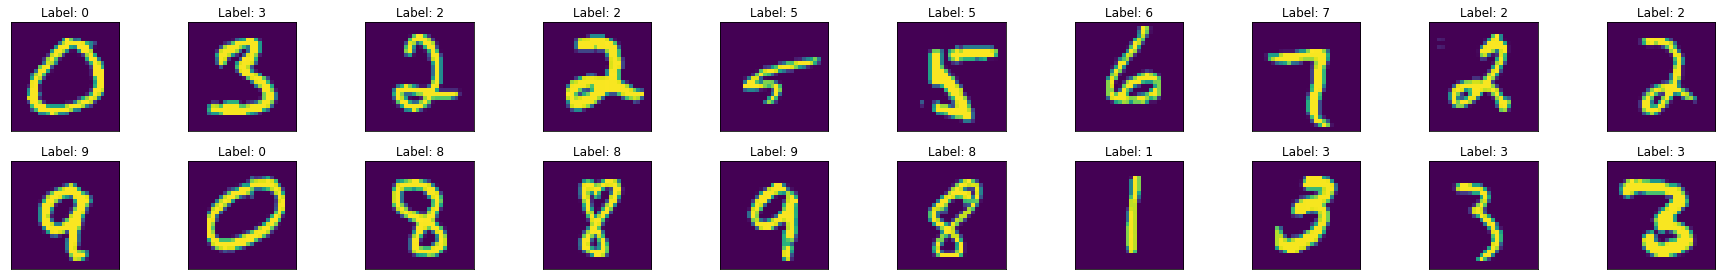

(torch.float32, torch.Size([1, 28, 28]), torch.Size([32, 1, 28, 28]))

In [5]:
images, labels = iter(validload).next()

fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.set_title(f'Label: {labels[i].item()}')
    ax.imshow(images[i].squeeze())

plt.tight_layout()
plt.show()

images[0].dtype, images[0].shape, images.shape

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.out = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return self.out(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet()
model = model.to(device)

In [22]:
opt = optim.Adam(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=7)
criterion = nn.CrossEntropyLoss()
epochs = 10

train_loss = []
valid_loss = []
accuracy   = []
valid_low = np.Inf


for e in range(epochs):
    running_tl = 0
    running_vl = 0
    running_ac = 0
    
    # backprop and and update
    model.train()
    for images, labels in trainload:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        t_cel = criterion(model(images.float()), labels)
        t_cel.backward()
        opt.step()
        running_tl += t_cel.item()
        
    # validation pass    
    with torch.no_grad():
        model.eval()
        for images, labels in validload:
            images, labels = images.to(device), labels.to(device)
            scores = model(images.float())
            ps = F.softmax(scores, dim=1)
            v_cel = criterion(scores, labels)
            pred = torch.argmax(ps, dim=1)
            running_ac += (pred == labels).cpu().numpy().mean()
            running_vl += v_cel.item()
    
    # Decay Learning Rate:
    print(f'Epoch {e} Learning Rate: {opt.param_groups[0]["lr"]} Validation Loss: {v_cel}')
    scheduler.step(v_cel)

    # get loss metrics for plotting later
    train_loss.append(running_tl/len(trainload))
    valid_loss.append(running_vl/len(validload))
    accuracy.append(running_ac/len(validload))

Epoch 0 Learning Rate: 5e-05 Validation Loss: 4.76837158203125e-07
Epoch 1 Learning Rate: 5e-05 Validation Loss: 1.049041748046875e-05
Epoch 2 Learning Rate: 5e-05 Validation Loss: 2.0742416381835938e-05
Epoch 3 Learning Rate: 5e-05 Validation Loss: 0.00017571449279785156
Epoch 4 Learning Rate: 5e-05 Validation Loss: 0.023056864738464355
Epoch 5 Learning Rate: 5e-05 Validation Loss: 8.821487426757812e-06
Epoch 6 Learning Rate: 5e-05 Validation Loss: 0.07546424865722656
Epoch 7 Learning Rate: 5e-05 Validation Loss: 0.016275882720947266
Epoch 8 Learning Rate: 5e-05 Validation Loss: 0.00017690658569335938
Epoch 9 Learning Rate: 5e-06 Validation Loss: 8.106231689453125e-06


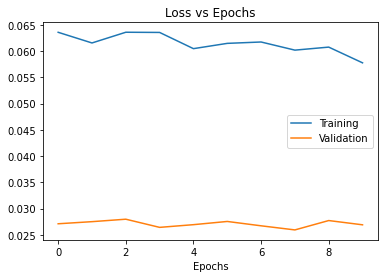

In [25]:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.legend()

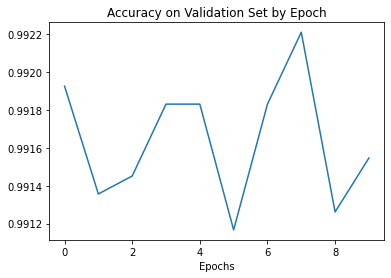

In [26]:
plt.title('Accuracy on Validation Set by Epoch')
plt.xlabel('Epochs')
plt.plot(accuracy)

In [27]:
torch.save(model.state_dict(), 'alltrans_40e.pt')
accuracy[-1]

0.9915463525835866

# Predictions of Kaggle Competition Data:
Now that we have a model that is doing quite well on validation set, let's put it to the test in our competition.

In [28]:
comp_data = pd.read_csv('data/test.csv')
comp_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
comp_set = MNIST(comp_data, labels=False, transform=tfs)
comp_loader = DataLoader(comp_set, batch_size=32, num_workers=0, shuffle=False)

In [30]:
predictions = np.array([])

for images in comp_loader:
    images = images.to(device).float()
    scores = model(images)
    ps = F.softmax(scores, dim=1)
    preds = torch.argmax(ps, dim=1).cpu()
    predictions = np.append(predictions, preds)
    

In [31]:
predictions = predictions.astype(np.int)

In [32]:
sub_df = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1),
                       'Label': predictions})

sub_df.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,9
6,7,0
7,8,3
8,9,0
9,10,3


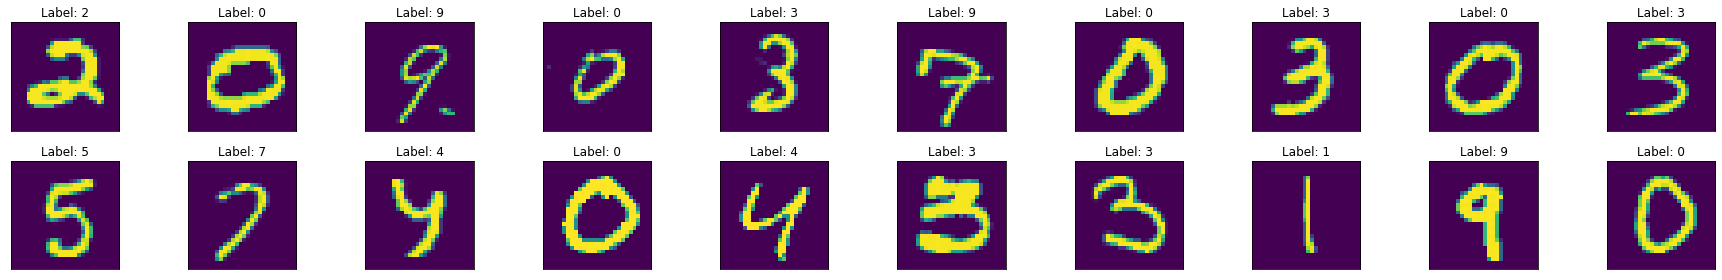

In [33]:
images = iter(comp_loader).next()

fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.set_title(f'Label: {sub_df.loc[i, "Label"]}')
    ax.imshow(images[i].squeeze())

plt.tight_layout()
plt.show()

Looks pretty good!

In [34]:
sub_df.to_csv('submission_LeNet.csv', index=False)

In [37]:
! kaggle competitions submit -c digit-recognizer -f submission_LeNet.csv -m "same as last +10 epochs"

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 65.1kB/s]
Successfully submitted to Digit Recognizer